# Clasificación usando Lenguaje Natural

In [0]:
#librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers, backend

Using TensorFlow backend.


In [0]:
# pip install nltk

In [0]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Package biocreative_ppi is already up-to-date!
       | Downloading package brown to /root/nltk_data...
       |   Package brown is already up-to-date!
       | Downloading package brown_tei to /root/nltk_data...
       |   Package brown_tei is already up-to-date!
       | Downloading package cess_cat to /root/nltk_data...
       |   Package cess_cat is already up-to-date!
       | Down

True

In [0]:
from nltk.tokenize import sent_tokenize

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk.tokenize import word_tokenize, regexp_tokenize

# Define algunas características iniciales

In [0]:
vocab_size = 37069 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 120  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [0]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = []
print(len(stopwords))

0


In [0]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [0]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))
# Expected Output
# 158314

69171
69171
69171
69171


In [0]:
# primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Expected Output
# 158314
# 158314

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



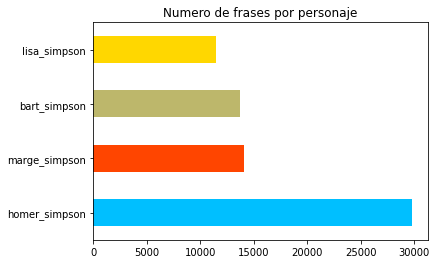

In [0]:
#Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [0]:
sentences[:4]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom']

# Separa datos de entrenamiento y validación 

In [0]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 126651 train
# 31663 validation

55336
55336
55336
13835
13835


In [0]:
train_sentences[:3]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide']

In [0]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'bart_simpson']

In [0]:
wordtk =  ' '.join(train_sentences)

In [0]:
tokenstk = regexp_tokenize(wordtk, pattern="\w+")

In [0]:
#para generar n-gramas
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [ ' '.join(grams) for grams in trigrama]

In [0]:
len(trigrama)

477691

In [0]:
#grafica con los trigramas
freq = nltk.FreqDist(trigrama)
freqnew = []
for key,val in freq.items():
  if (val>1):
    freqnew.append(str(key))

In [0]:
len(freqnew)

37069

In [0]:
##para generar n-gramas
#from nltk.util import ngrams
#cuatrigrama = ngrams(tokenstk,4)
#cuatrigrama = [ ' '.join(grams) for grams in cuatrigrama]

In [0]:
#grafica con los cuatrigramas
#freq = nltk.FreqDist(cuatrigrama)
#freq.plot(20, cumulative=False, title = "4-grama")

In [0]:
print(len(trigrama))
print(len(cuatrigrama))

477691
477690


# crea el vocabulario

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,split= ' ')
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences, padding=padding_type, maxlen=max_length))

TypeError: ignored

In [0]:
word_index

{'<OOV>': 1,
 'i': 2,
 'you': 3,
 'the': 4,
 'a': 5,
 'to': 6,
 'and': 7,
 'it': 8,
 'of': 9,
 'that': 10,
 'my': 11,
 'is': 12,
 'in': 13,
 'this': 14,
 'me': 15,
 'im': 16,
 'for': 17,
 'oh': 18,
 'your': 19,
 'what': 20,
 'dont': 21,
 'have': 22,
 'on': 23,
 'no': 24,
 'but': 25,
 'we': 26,
 'its': 27,
 'be': 28,
 'just': 29,
 'do': 30,
 'all': 31,
 'well': 32,
 'so': 33,
 'not': 34,
 'are': 35,
 'like': 36,
 'get': 37,
 'with': 38,
 'was': 39,
 'youre': 40,
 'can': 41,
 'know': 42,
 'now': 43,
 'dad': 44,
 'thats': 45,
 'out': 46,
 'up': 47,
 'at': 48,
 'if': 49,
 'hey': 50,
 'bart': 51,
 'right': 52,
 'go': 53,
 'one': 54,
 'here': 55,
 'were': 56,
 'marge': 57,
 'how': 58,
 'homer': 59,
 'ill': 60,
 'got': 61,
 'about': 62,
 'he': 63,
 'think': 64,
 'cant': 65,
 'they': 66,
 'look': 67,
 'gonna': 68,
 'why': 69,
 'see': 70,
 'good': 71,
 'okay': 72,
 'there': 73,
 'want': 74,
 'our': 75,
 'yeah': 76,
 'did': 77,
 'little': 78,
 'from': 79,
 'mom': 80,
 'could': 81,
 'lisa': 82,
 

In [0]:
help(Tokenizer)

Help on class Tokenizer in module keras_preprocessing.text:

class Tokenizer(builtins.object)
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolean. Whether to convert the texts to lowercase.
 |      split: str. Separator for word splitting.
 |      char_level: if True, every character will be treated as a token.


In [0]:
train_sentences

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom',
 'do you know where i could find him',
 'the train how like him traditional yet environmentally sound',
 'i see he touched you too',
 'hey thanks for your vote man',
 'well you got that right thanks for your vote girls',
 'well dont sweat it just so long as a couple of people did right milhouse',
 'lewis',
 'somebody must have voted',
 'uh oh',
 '',
 'i demand a recount',
 'no',
 'mr bergstrom hey mr bergstrom',
 'hey lisa indeed',
 'oh i mean were you just going to leave just like that',
 'you cant go youre the best teacher ill ever have',
 'oh please',
 'but i need you too',
 'i i understand mr bergstrom im going to miss you',
 'thank you mr bergstrom',
 'so i guess this is it it you dont mind ill just run alongside the train as it speeds you from my life',
 'never thrown a party what about that big bash we had with all the champagne and musicians and holy men and eve

In [0]:
print((train_sequences[0]))
print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

# Expected Ouput
# 12
# 120
# 3
# 120
# 10
# 120

[370, 144, 1]
120


In [0]:
train_sequences[:2]

[[370, 144, 1], [10, 156, 12, 814, 582]]

In [0]:
train_padded[:2]

array([[370, 144,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 10, 156,  12, 814, 582,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))


In [0]:
validation_sequences[:2]

# Expected output
# 31663
# (31663, 120)

[[], [260, 1, 1, 35, 3, 68, 30, 6, 15]]

In [0]:
validation_padded[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [260,   1,   1,  35,   3,  68,  30,   6,  15,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 31663
# (31663, 120)

13835
(13835, 120)


In [0]:
label_size = 500
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq[3])
print(training_label_seq[5])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq[3])
print(validation_label_seq[5])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[5]
[5]
[4]
[5]
[5]
(55336, 1)
[2]
[2]
[2]
[2]
[4]
(13835, 1)


In [0]:
# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])


In [0]:
label_seq[:5]

array([5, 5, 4, 5, 5])

In [0]:
max(validation_label_seq)

5

# transform target to one-hot codification

## primero crea etiquetas numéricas

In [0]:
from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
y_test = encoder.transform(validation_label_seq)

In [0]:
max(y_train)

3

In [0]:
y_train.shape

(55336,)

In [0]:
y_train

array([3, 3, 2, ..., 0, 0, 1])

In [0]:
y_test

array([0, 0, 0, ..., 1, 3, 3])

## one hot

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
num_classes

4

In [0]:
y_train.shape

(55336, 4)

In [0]:
y_train[0]

array([0., 0., 0., 1.], dtype=float32)

In [0]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

## Modelo 1

| dropout | conv1D | LSTM | accuracyTrain | accuracyValidation | epoch |
|---------|:------:|:----:|:-------------:|:------------------:|:-----:|
|         |        |      |    0.3645     |       0.3478       |  13   |
|    1    |   1    |      |    0.3751     |       0.3462       |  11   |
|         |   1    |      |    0.3761     |       0.3455       |  10   |
|    1    |        |      |    0.3668     |       0.3527       |  15   |
|    1    |        |   1  |    0.3730     |       0.3416       |  13   |

## Modelo 2 con 9 Labels

| spatial Dropout1d | BIDLSTM | Dropout | Dense | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|::|::|::|::|::|::|::|::|::|
|1|2|2|2|1.2943|0.5236|1.5963|0.4304|23|



## Modelo 3 con 4 Labels - 20 ephocs

| Conv1D | SpatialDroout1D | BIDLSTM | Dropout | Densa | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| | |1|2|2|1.0705|0.5387|1.1504|0.4953|10|
|1|1||2|2|1.0209|0.5645|1.1661|0.4930|7|
|1||1|2|2|1.0497|0.5510|1.1570|0.4941|5|
||1|1|2|2|1.0601|0.5453|1.1625|0.4911|9|
|1|1|1|2|2|1.0479|0.5516|1.1565|0.4898|6|
|2| | |2|2|1.0265|0.5626|1.1968|0.4835|6|
| | | |2|2|1.0691|0.5402|1.1626|0.4978|10|
| | | |3|3|1.0789|0.5394|1.1517|0.4966|11|

In [0]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.Conv1D(120, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 32)           64000     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 116, 200)          32200     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 112, 120)          120120    
_________________________________________________________________
global_average_pooling1d_15  (None, 120)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 120)               14520     
_________________________________________________________________
dropout_23 (Dropout)         (None, 120)             

## Entrenamos el modelo

In [0]:
num_epochs = 40
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[callback])
print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Epoch 1/40
1730/1730 - 10s - loss: 1.2513 - accuracy: 0.4476 - val_loss: 1.2145 - val_accuracy: 0.4658
Epoch 2/40
1730/1730 - 9s - loss: 1.1632 - accuracy: 0.4955 - val_loss: 1.1536 - val_accuracy: 0.4891
Epoch 3/40
1730/1730 - 9s - loss: 1.1042 - accuracy: 0.5248 - val_loss: 1.1322 - val_accuracy: 0.5004
Epoch 4/40
1730/1730 - 9s - loss: 1.0678 - accuracy: 0.5419 - val_loss: 1.1429 - val_accuracy: 0.5031
Epoch 5/40
1730/1730 - 9s - loss: 1.0372 - accuracy: 0.5586 - val_loss: 1.1580 - val_accuracy: 0.4867
Epoch 6/40
1730/1730 - 10s - loss: 1.0051 - accuracy: 0.5756 - val_loss: 1.1747 - val_accuracy: 0.4880
Epoch 7/40
1730/1730 - 10s - loss: 0.9719 - accuracy: 0.5935 - val_loss: 1.2090 - val_accuracy: 0.4863

En la epoca 7 la precision de validación dejó de mejorar.


## Graficamos

In [0]:
string='accuracy'
print(history.history[string])
print(history.history['val_'+string])

[0.46470651030540466, 0.5170232653617859, 0.5339200496673584, 0.5419618487358093, 0.5499494075775146]
[0.49129021167755127, 0.5045175552368164, 0.5026382207870483, 0.5000361204147339, 0.495771586894989]


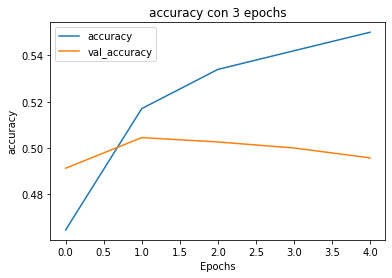

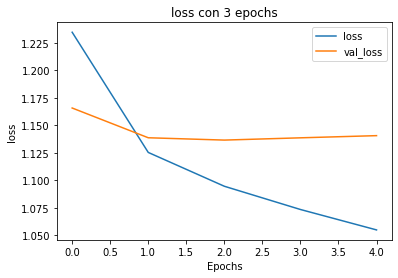

In [0]:
def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
#convierte palabras en texto (NO LO USAMOS AÚN)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence([862, 54])

In [0]:
#Pesos de la primera capa
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

In [0]:
weights

## funcion clasificadora

In [0]:
validation_sentences[:2]

In [0]:
sq = model.predict_classes(validation_padded[:2])
sq

In [0]:
label_tokenizer.sequences_to_texts([sq])

In [0]:
def classifier (sentence): 
  sentences = []
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)
  # preprocess stopwords
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  sentences.append(sentence)

  sentences = tokenizer.texts_to_sequences(sentences) #transforms each text in texts to a sequence of integers
  sentences_padded = np.array(pad_sequences(sentences, padding=padding_type, maxlen=max_length))

  #prob = model.predict(sentences_padded)
  prediction = model.predict_classes(sentences_padded)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [0]:
classifier('are you sure lord')

In [0]:
classifier('can his funeral be on a school day')

In [0]:
classifier("We should go to the bar")

## exportar archivos

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Referencias
- Aprendizaje profundo, [Ciencia de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos/tree/master/Cuadernos)